# Описание проекта

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». 

Цель: нужно решить, где бурить новую скважину.

Задача: построить модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализировать возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

Условия задачи:
- Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
- При разведке региона проводится исследование 500 точек.
- Бюджет на разработку месторождений — 10 млрд рублей, стоимость бурения одной скважины — 50 млн рублей.
- Один баррель сырья приносит 4500 рублей прибыли.
- Не рассматривать регионы, в которых риск убытков выше 2.5%. Из оставшихся выбирается регион с наибольшей средней прибылью.

# 1. Загрузка и подготовка данных

Подгрузим необходимые библиотеки:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from scipy import stats as st
%matplotlib inline

In [2]:
# Загрузим и сохраним данные по каждому региону в отдельные переменные
geo_data_0 = pd.read_csv('/datasets/geo_data_0.csv')
geo_data_1 = pd.read_csv('/datasets/geo_data_1.csv')
geo_data_2 = pd.read_csv('/datasets/geo_data_2.csv')

Посмотрим на первые пять строк каждого датасета.

In [3]:
geo_data_0.head()

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


In [4]:
geo_data_1.head()

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


In [5]:
geo_data_2.head()

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


Посмотрим на общую информацию по каждому датасету:

In [6]:
geo_data_0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [7]:
geo_data_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [8]:
geo_data_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [9]:
# в столбце id приведены идентификаторы скважины. Посчитаем уникальные для каждого региона
for i in ((geo_data_0.id, 'Скважина №1'), (geo_data_1.id, 'Скважина №2'), (geo_data_2.id, 'Скважина №3')):
    print('{}, всего уникальных объектов {} из {}'.format(i[1], len(i[0].unique()), len(i[0])))

Скважина №1, всего уникальных объектов 99990 из 100000
Скважина №2, всего уникальных объектов 99996 из 100000
Скважина №3, всего уникальных объектов 99996 из 100000


Полученная информация говорит о том, по некоторым месторождениям есть более одной записи в датасете. Врядли это сильно повлияет на конечный результат.

### Выводы:

1. Данные загружены корректно и имеют по 100000 объектов в каждом датасете.
2. Для дальнейшего обучения потребуется удалить столбец с id каждого датасета, так как он не несет смысловой нагрузки для обучения модели.

# 2. Обучение и проверка модели

In [10]:
# удалим столбец id из каждого датасета
for i in (geo_data_0, geo_data_1, geo_data_2):
    i.drop('id', axis=1, inplace=True)

In [11]:
# самопроверка
geo_data_1.head()

,f0,f1,f2,product
0,-15.001348,-8.276000,-0.005876,3.179103
1,14.272088,-3.475083,0.999183,26.953261
2,6.263187,-5.948386,5.001160,134.766305
3,-13.081196,-11.506057,4.999415,137.945408
4,12.702195,-8.147433,5.004363,134.766305


### 2.1  Разбиение данных на обучающую и валидационную выборки в соотношении 75:25.

In [12]:
# напишем функцию, с помощью которого из исходного датасета выделим признаки и целевой признак, 
# а возвратит функция данные, разбитые на обучающую и валидационные выборки

def prepare_data(data):
    # разбиваем датасет на выборки с целевым признаком и остальными признаками
    features = data.drop('product', axis=1)
    target = data['product']
    
    # разбиваем выборки в соотношении 75:25 и возвращаем результаты
    return train_test_split(features, target, test_size=0.25, random_state=42)

In [13]:
# обучающие и валидационные выборки для первого региона
X0_train, X0_valid, y0_train, y0_valid = prepare_data(geo_data_0)

# обучающие и валидационные выборки для второго региона
X1_train, X1_valid, y1_train, y1_valid = prepare_data(geo_data_1)

# обучающие и валидационные выборки для третьего региона
X2_train, X2_valid, y2_train, y2_valid = prepare_data(geo_data_2)

### 2.2 Обучение модели и сделайте предсказания на валидационной выборке.

По заданию требуется обучить модель и напечатать средний запас сырья и RMSE модели, а также сохранить предсказания и правильные ответы на валидационной выборке. Так как набора данных у меня 3, напишем функцию для вывода среднего запаса сырья и RMSE модели, которая будет возвращать датафрейм со значениями предсказаний и вероятностями предсказаний:

In [14]:
def train_model(X_train, X_valid, y_train, y_valid, title):
    model = LinearRegression()
    
    # тренеруем модель и проверям качество на валидационных данных
    model.fit(X_train, y_train)
    result = pd.DataFrame(columns=['true', 'predict'])
    
    # сохраним результаты в result
    result['true'] = y_valid
    result['predict'] = model.predict(X_valid)
    
    # выведем на экран значения среднего запаса сырья месторождения и RMSE модели
    print('Средний запас сырья для одного месторождения региона №{} = {}'.format(title, pd.concat([y_train, y_valid]).mean()))
    print('RMSE модели равен {}'.format(np.sqrt(mean_squared_error(y_valid, result['predict']))))
    
    return result

In [15]:
# обучим модель для первого региона и посмотрим на ключевые показатели, сохраним предсказания и правильные значения в переменной
pred_0 = train_model(X0_train, X0_valid, y0_train, y0_valid, 1)

Средний запас сырья для одного месторождения региона №1 = 92.50000000000001
RMSE модели равен 37.75660035026169


In [16]:
# обучим модель для второго региона и посмотрим на ключевые показатели, сохраним предсказания и правильные значения в переменной
pred_1 = train_model(X1_train, X1_valid, y1_train, y1_valid, 2)

Средний запас сырья для одного месторождения региона №2 = 68.825
RMSE модели равен 0.8902801001028828


In [17]:
# обучим модель для третьего региона и посмотрим на ключевые показатели, сохраним предсказания и правильные значения в переменной
pred_2 = train_model(X2_train, X2_valid, y2_train, y2_valid, 3)

Средний запас сырья для одного месторождения региона №3 = 95.00000000000001
RMSE модели равен 40.145872311342174


Построим гистограммы для каждого региона и посмотрим на распределение значений.

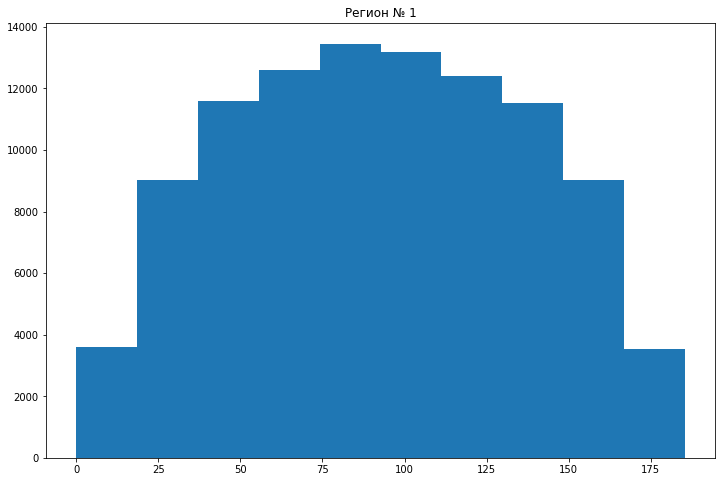

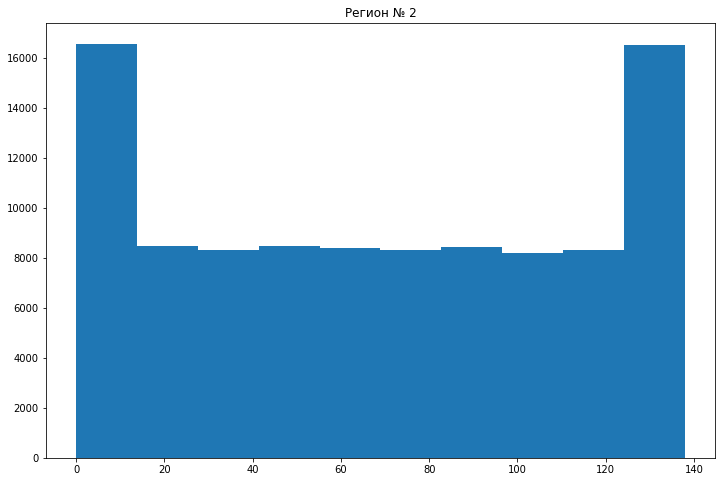

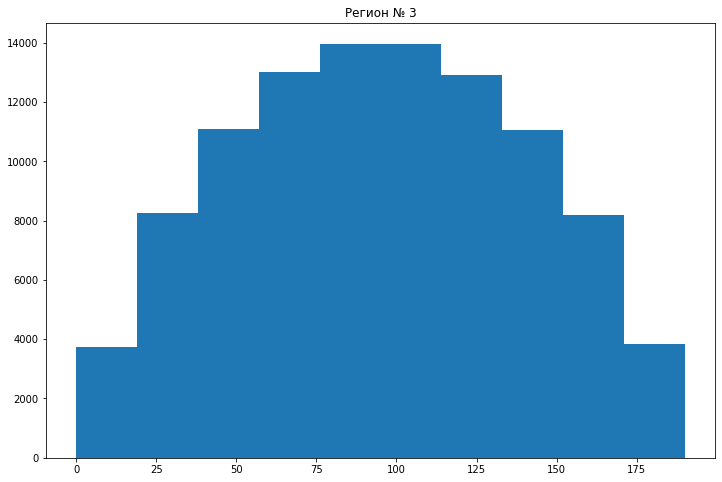

In [18]:
for i in ((geo_data_0['product'], 'Регион № 1'), (geo_data_1['product'], 'Регион № 2'), (geo_data_2['product'], 'Регион № 3')):
    plt.figure(figsize=(12, 8))
    plt.hist(i[0])
    plt.title(i[1])

### Выводы:

1. По исходным данным были обучены модели линейной регрессии, посчитаны ошибки RMSE модели, который равны:
  - 37.756 для первого региона при средней добычи с одного месторождения 92.5 тыс. баррелей;
  - 0.89 для второго региона при средней добычи с одного месторождения 68.825 тыс. баррелей;
  - 40.14 для третьего региона при средней добычи с одного месторождения 95 тыс. баррелей;
2. По гистограммам видно, что для первого и третьего региона данные имеют нормально распределение, данные по второму региону имеют выбросы на значениях 0-10 и 130-140, при этом остальные значения распределены примерно равномерно.


# 3. Подготовка к расчёту прибыли

### 3.1 Сохранить в коде все ключевые значения для расчётов.

Условия задачи:
1. Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
1. При разведке региона проводится исследование 500 точек.
1. Бюджет на разработку месторождений — 10 млрд рублей, стоимость бурения одной скважины — 50 млн рублей.
1. Один баррель сырья приносит 4500 рублей прибыли.
1. Не рассматривать регионы, в которых риск убытков выше 2.5%. Из оставшихся выбирается регион с наибольшей средней прибылью.

In [19]:
# количество исследуемых точек
n_field = 500

# бюджет на разработку месторождения
budget = 10 * 10 ** 9

# стоимость бурения одной скважины
one_well = 50 * 10 ** 6

# прибыль от одной тысячи баррелей сырья
one_profit = 4500 * 1000

# порог убытков
alpha = 0.025

### 3.2 Посчитайте минимальный средний объём сырья в месторождениях региона, достаточный для его разработки. Напишите выводы.

In [20]:
# нужно выбрать такой объем, при котором обеспечивалась бы нулевая операционная прибыль
# сколько всего можно пробурить скважин за такой бюджет
total_well = int(budget / one_well)
print('Всего можно пробурить в рамках бюджета - {} скважин'.format(total_well, 2))

# средний объем сырья, достаточный для разработки месторождения
min_mean_volume = budget / (one_profit * total_well)
print('Минимальный средний объем добычи в месторождениях региона, достаточный для его разработки, {} тыс. баррелей'.format(round(min_mean_volume, 2)))

Всего можно пробурить в рамках бюджета - 200 скважин
Минимальный средний объем добычи в месторождениях региона, достаточный для его разработки, 11.11 тыс. баррелей


### Выводы:

1. Для того, чтобы обеспечить операционную прибыль, равной нулю или более нужно добывать в месторождениях регионов не менее 11.11 тыс. баррелей.
2. В рамках бюджета можно пробурить 200 скважин.

### 3.3. Напишите функцию для расчёта прибыли по набору отобранных месторождений и предсказаний модели.

In [21]:
def revenue(target_subsample, probs_subsample, count):
    pred = probs_subsample.sort_values(ascending=False)
    selected = target_subsample[pred.index][:count]
    return one_profit * selected.sum() - budget

# 4. Расчёт прибыли и рисков 

### 4.1 Bootstrap, построение 95 % доверительного интервала и расчет средней прибыли.

Применим технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли. Найдем среднюю прибыль, 95%-й доверительный интервал.

In [22]:
# зададим состояние генератора случайных чисел
state = np.random.RandomState(12345)
    
def ci_and_mean(data):
    # сбросим индексы у датафрейма
    data = data.reset_index(drop=True)
    
    values = []
    for i in range(1000):
        target_subsample = data['true'].sample(n=n_field, random_state=state, replace=True)
        probs_subsample = data['predict'][target_subsample.index]
        values.append(revenue(target_subsample, probs_subsample, total_well))

    # преобразуем список в объект Series
    values = pd.Series(values)
    
    # оценим риск получения нулевой прибыли функцией percentileofscore из модуля stats библиотеки scipy
    # первый аргумент выборка, второй значение, менее которого мы ожидаем получить результат
    risk = st.percentileofscore(values, 0)

    confidence_interval = st.t.interval(0.95, len(values)-1, values.mean(), values.sem())
 
    print('95%-ый доверительный интервал: ', confidence_interval)
    print('Средняя выручка со всех скважин, млрд. руб.: ', values.mean() / 10**9)
    print('Шанс получить нулевую прибыль равен {}'.format(risk))

In [23]:
# расчет по первому месторождению
ci_and_mean(pred_0)

95%-ый доверительный интервал:  (94187611038.82689, 94531064403.94637)
Средняя выручка со всех скважин, млрд. руб.:  94.35933772138662
Шанс получить нулевую прибыль равен 0.0


In [24]:
# расчет по второму месторождению
ci_and_mean(pred_1)

95%-ый доверительный интервал:  (94852765914.48546, 95118614423.8503)
Средняя выручка со всех скважин, млрд. руб.:  94.98569016916788
Шанс получить нулевую прибыль равен 0.0


In [25]:
# расчет по третьему месторождению
ci_and_mean(pred_2)

95%-ый доверительный интервал:  (93948992689.50804, 94304465290.26259)
Средняя выручка со всех скважин, млрд. руб.:  94.12672898988531
Шанс получить нулевую прибыль равен 0.0


### Выводы:

1. Проанализированы примерные средние прибыли с разработки месторождений 3-х регионов.
2. Все регионы показывают большие прибыли при разработке (в 9 - 10 раз больше первоначальных вложений).
3. По полученным средним значениям для прибыли, а также по анализу доверительного интервала, наиболее подходящий для осваивания месторождений район № 2.

In [26]:
st.percentileofscore(pred_1['predict'], 0)

2.2